<a href="https://colab.research.google.com/github/saranshgupta121/VIDOOLY_LOGO/blob/master/flicker_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import imutils
import cv2
import copy
#from google.colab.patches import cv2_imshow

In [0]:
width=224
height=224
vgg16_conv_base = VGG16(weights="imagenet", include_top=False,input_shape=(width,height,3)) # false removes last three layers ie three dense layers(including the classification layer) and the shapes of all the layers are reset    
print(vgg16_conv_base.summary())
for layer in vgg16_conv_base.layers[:]:
    layer.trainable=False
print(vgg16_conv_base.layers[-1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
x = Flatten(name='flatten')(vgg16_conv_base.layers[-1].output)
x = Dense(256, activation='relu', name='fc1')(x)
#x = Dense(2048, activation='relu', name='fc3')(x)
#x = Dense(1024, activation='relu', name='fc4')(x)
#x = Dense(512, activation='relu', name='fc5')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
#x=Dense(512,activation='relu',name='fc4')(d2)
#d4=Dense(256,activation='relu',name='fc4')(d3)
x=Dense(27,activation='softmax',name='preditions')(x)

vgg16_modified=Model(inputs=[vgg16_conv_base.input],outputs=x)
vgg16_modified.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________

In [0]:
#For augmenting the tranining set
train_datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

train_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 32
 
train_dir="/content/drive/My Drive/Train_Flicker"
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(width,height),
        batch_size=train_batchsize,
        class_mode='categorical')
vgg16_modified.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

print(train_generator.samples/train_generator.batch_size)## hepls in calculating steps per epoch

Found 810 images belonging to 27 classes.
25.3125


In [0]:
history = vgg16_modified.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
26/25 [==============================] - 241s 9s/step - loss: 2.2858 - acc: 0.4255
Epoch 2/5
26/25 [==============================] - 8s 305ms/step - loss: 0.4763 - acc: 0.9287
Epoch 3/5
26/25 [==============================] - 8s 306ms/step - loss: 0.1724 - acc: 0.9904
Epoch 4/5
26/25 [==============================] - 8s 305ms/step - loss: 0.0863 - acc: 0.9964
Epoch 5/5
26/25 [==============================] - 8s 306ms/step - loss: 0.0503 - acc: 0.9976


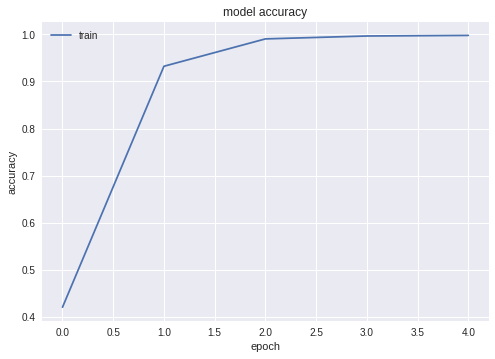

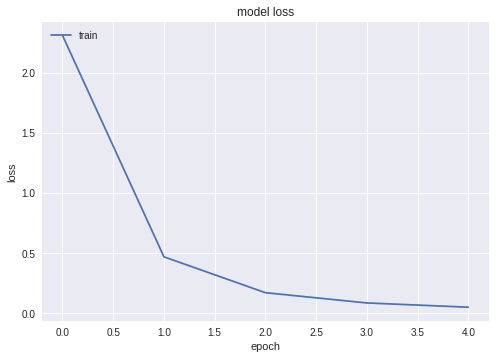

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [273]:
logos_name=['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks', 'Intel', 'Texaco', 'Unicef', 'Vodafone' , 'Yahoo']

X = []
#labels=[]
for filename in os.listdir('/content/drive/My Drive/Test_Flicker'):
    X.append(img_to_array(load_img('/content/drive/My Drive/Test_Flicker/'+filename,target_size=(224, 224))))
X = np.array(X,dtype=np.float32)
Xtest = 1.0/255*X
predicted_name=[]

predictions = vgg16_modified.predict(Xtest,steps=None,batch_size=None,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
for i in range(len(predicted_classes)):
  predicted_name.append(logos_name[predicted_classes[i]])
  



270/270 [==============================] - 3s 10ms/step


In [274]:
print(predicted_name)

['Ford', 'Apple', 'Vodafone', 'Sprite', 'Vodafone', 'Nbc', 'Yahoo', 'Heineken', 'Vodafone', 'Sprite', 'McDonalds', 'Pepsi', 'Fedex', 'Ford', 'Sprite', 'Porsche', 'Adidas', 'Yahoo', 'Ferrari', 'Unicef', 'Ferrari', 'Nike', 'Google', 'McDonalds', 'Intel', 'Google', 'Yahoo', 'BMW', 'Google', 'Heineken', 'Google', 'Pepsi', 'Mini', 'Vodafone', 'Apple', 'Yahoo', 'Apple', 'BMW', 'RedBull', 'Mini', 'Citroen', 'Apple', 'Porsche', 'Pepsi', 'Intel', 'Intel', 'Ferrari', 'Apple', 'Mini', 'Nike', 'Apple', 'Ford', 'Citroen', 'Vodafone', 'Adidas', 'Citroen', 'Apple', 'Unicef', 'Yahoo', 'Citroen', 'Sprite', 'Citroen', 'Apple', 'Vodafone', 'Ferrari', 'Mini', 'RedBull', 'Sprite', 'BMW', 'Adidas', 'Adidas', 'Citroen', 'BMW', 'Sprite', 'Ferrari', 'Sprite', 'DHL', 'Heineken', 'Unicef', 'Mini', 'Mini', 'Ford', 'Intel', 'Cocacola', 'Vodafone', 'Ford', 'Pepsi', 'Heineken', 'Heineken', 'Citroen', 'Vodafone', 'RedBull', 'Unicef', 'Sprite', 'Yahoo', 'Pepsi', 'Unicef', 'BMW', 'Unicef', 'Adidas', 'Cocacola', 'Ford',

In [0]:
X_test_copy=copy.deepcopy(Xtest)

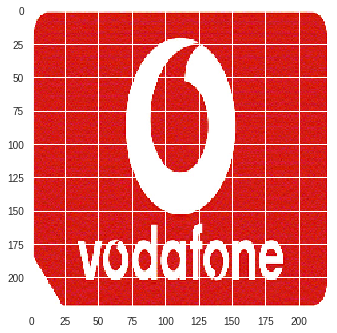

In [299]:
plt.imshow(X_test_copy[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22 21 32907772.0 1.0
200 200


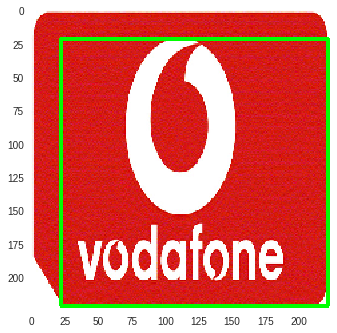

In [314]:
i=2 # specify an index between 0 to 270 to see detection on that particular image
# load the image image, convert it to grayscale, and detect edges
file=predicted_name[i]
file=file+'.jpg'
template=[]
for filenames in os.listdir('/content/drive/My Drive/Template Matching/'):
  template.append(cv2.imread('/content/drive/My Drive/Template Matching/'+filenames,0))
  
bin_box=[]
bin_template=[]
  
for j in range(0,len(template)):
  t=np.asarray(template[j])
  (tH, tW) = t.shape[:2]

  gray = cv2.cvtColor(X_test_copy[i]*255, cv2.COLOR_BGR2GRAY)
  found = None
  # looping over differernt scales of images
  for scale in np.linspace(0.2, 1.0, 20)[::-1]:
      resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
      r = gray.shape[1] / float(resized.shape[1])

      # if the resized image is smaller than the template, then break
      # from the loop
      if resized.shape[0]<tH or resized.shape[1]<tW:break
      edged=resized
      t=t.astype(np.uint8)
      edged=edged.astype(np.uint8)
      result = cv2.matchTemplate(edged, t, cv2.TM_CCOEFF)
      (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)
      clone = np.dstack([edged, edged, edged])
      if found is None or maxVal > found[0]:
          found = (maxVal, maxLoc, r)
          bin_box.append(found)
          bin_template.append([tH,tW])
          
#len(bin)
#print(bin)
#bin[0]
r_t=0
start_x=0
start_y=0
max_value_t=0
tH_t=0
tW_t=0
for k in range(0,len(bin_box)):
  if max_value_t<bin_box[k][0]:
    max_value_t=bin_box[k][0]
    r_t=bin_box[k][2]
    start_x,start_y=bin_box[k][1]
    tH_t,tW_t=bin_template[k]
        
print(start_x,start_y,max_value_t,r_t)
print(tH_t,tW_t)

output=X_test_copy[i].copy()
(endX, endY) = (int((start_x + tW_t) * r_t), int((start_y + tH_t) * r_t))
cv2.rectangle(output, (start_x, start_y), (endX, endY), (0, 255,0), 2)
#plt.imshow(X_test_copy[i])
plt.grid(b=None)
plt.imshow(output)